# Insurance Premium Prediction – Machine Learning Project

## Problem Statement
The objective of this project is to predict insurance premium prices based on customer demographic and health-related features.

## Business Objective
- Accurate premium pricing
- Risk assessment
- Data-driven decision making


In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error,mean_absolute_error,root_mean_squared_error, r2_score, mean_absolute_percentage_error

In [71]:
!gdown 1x9mMJ4CW7scpJbDAP12qbFHQsrB2T7dc

Downloading...
From: https://drive.google.com/uc?id=1x9mMJ4CW7scpJbDAP12qbFHQsrB2T7dc
To: /content/Insurance.csv
100% 30.8k/30.8k [00:00<00:00, 43.5MB/s]


In [72]:
df = pd.read_csv('Insurance.csv')

**1. Data Understanding:**

In [73]:
df.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000


In [74]:
df.shape

(986, 11)

In [75]:
df.duplicated().sum()

np.int64(0)

In [76]:
# Missing values
df.isna().sum()

,0
Age,0
Diabetes,0
BloodPressureProblems,0
AnyTransplants,0
AnyChronicDiseases,0
Height,0
Weight,0
KnownAllergies,0
HistoryOfCancerInFamily,0
NumberOfMajorSurgeries,0


**Insight: No missing values were observed, hence no imputation required.**

**2. Distribution Analysis(Continuous
variables)**

In [77]:
df.columns

Index(['Age', 'Diabetes', 'BloodPressureProblems', 'AnyTransplants',
       'AnyChronicDiseases', 'Height', 'Weight', 'KnownAllergies',
       'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries', 'PremiumPrice'],
      dtype='object')

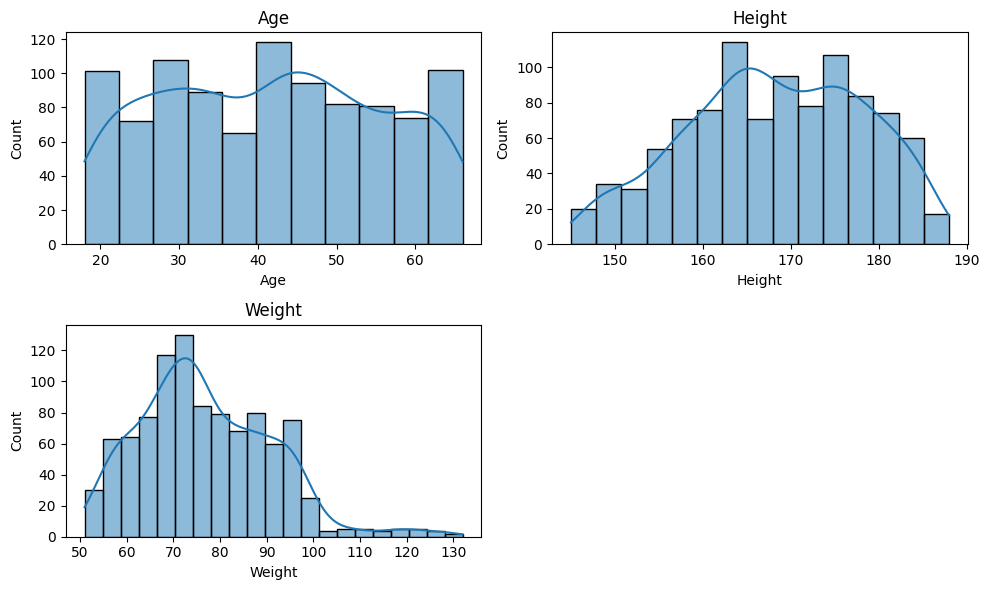

In [78]:
# create subplots
num_cols = ['Age','Height', 'Weight']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
axes = axes.ravel()
for ax,col in zip(axes,num_cols):
    sns.histplot(df[col], ax=ax, kde=True)
    ax.set_title(col)
for ax in axes[len(num_cols):]:
    ax.axis('off')
plt.tight_layout()
plt.show()

**3. Distribution Analysis(Discrete variables):**

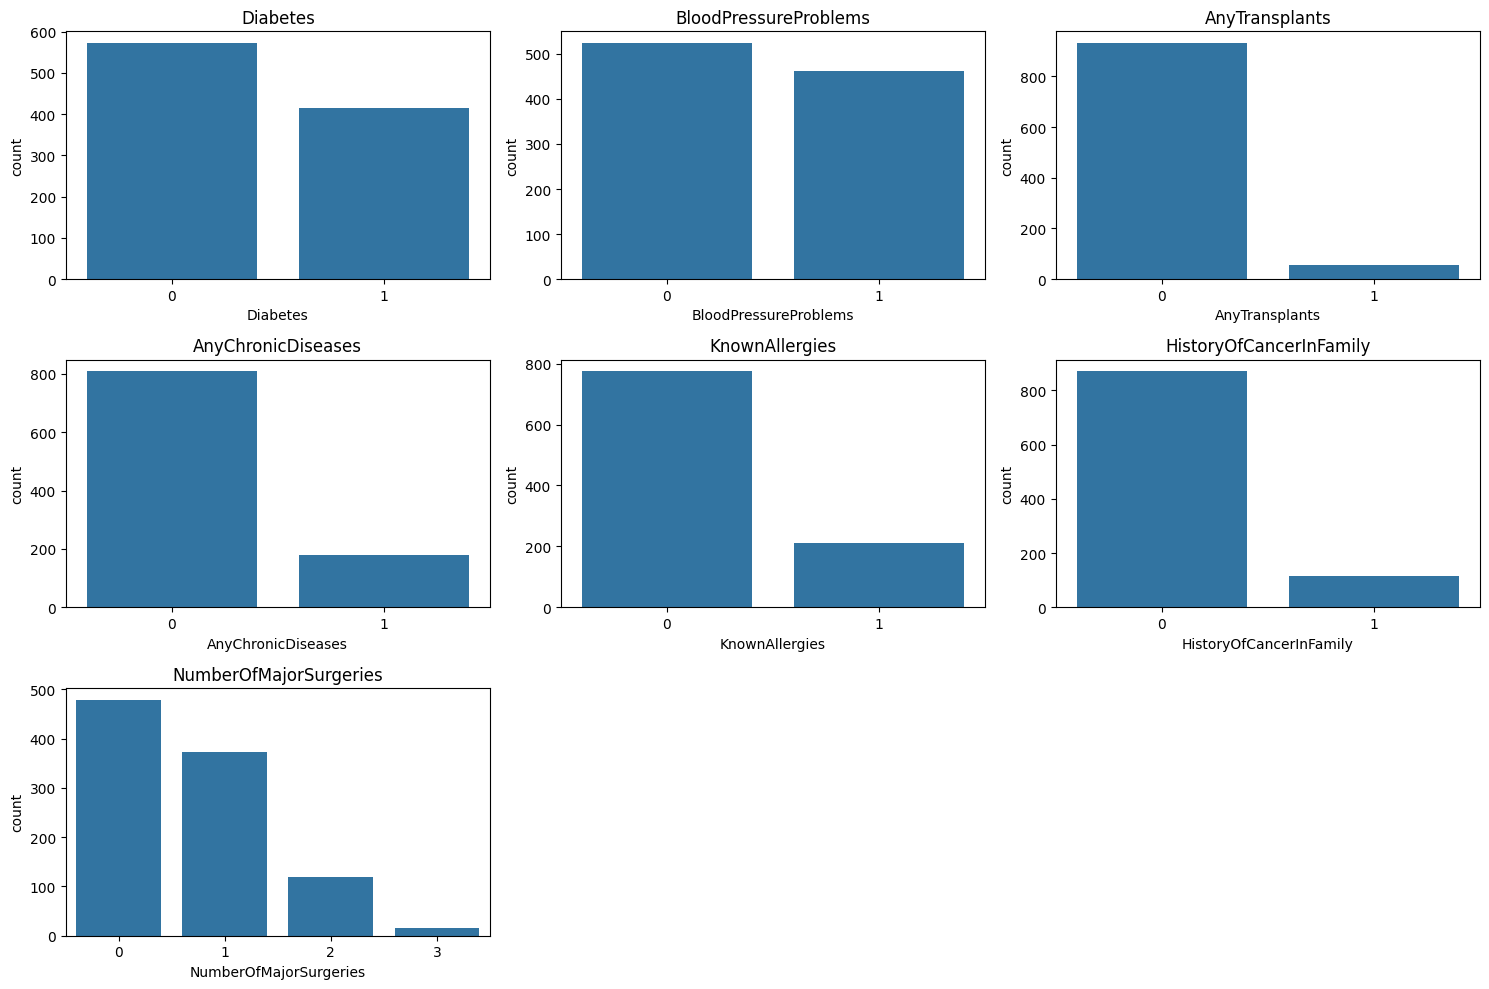

In [79]:
Key_cols = [
    'Diabetes', 'BloodPressureProblems', 'AnyTransplants',
    'AnyChronicDiseases','KnownAllergies',
    'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries'
]
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.ravel()

for ax,col in zip(axes,Key_cols):
    sns.countplot(x=df[col], ax=ax)
    ax.set_title(col)

for ax in axes[len(Key_cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()



**4. Target variable Analysis:**

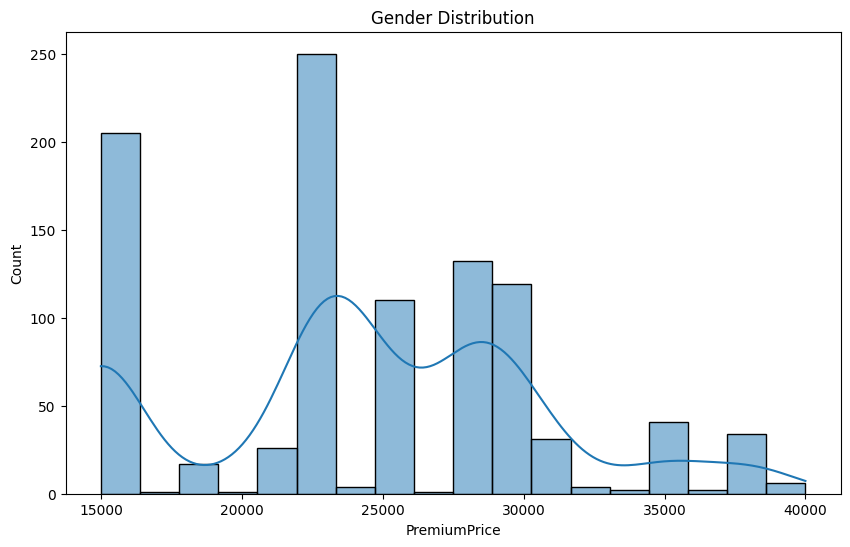

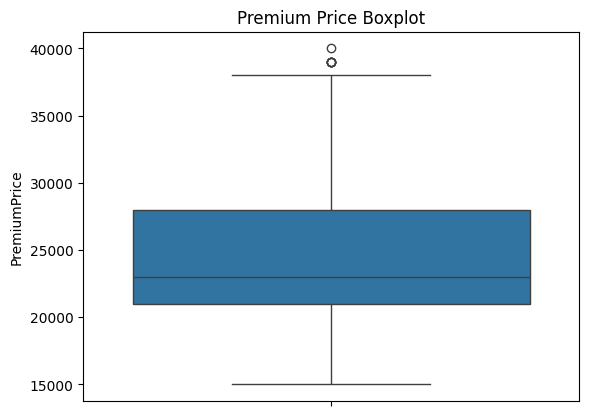

In [80]:
plt.figure(figsize=(10, 6))
sns.histplot(x=df['PremiumPrice'],kde=True)
plt.title('Gender Distribution')
plt.show()
sns.boxplot(y=df['PremiumPrice'])
plt.title('Premium Price Boxplot')
plt.show()

**5. Correlation Analysis**

**5.1 Correlation Matrix**

In [81]:

corr = df[num_cols + ['PremiumPrice']].corr()['PremiumPrice']

In [82]:
corr

,PremiumPrice
Age,0.697540
Height,0.026910
Weight,0.141507
PremiumPrice,1.000000


**5.2 Heatmap visualization**

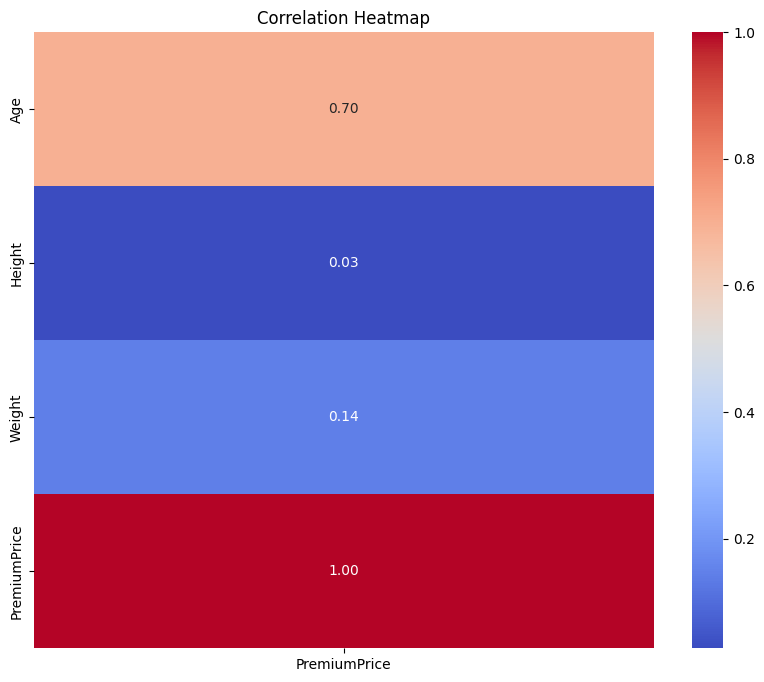

In [83]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr.to_frame(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

**5.3 Correlation Target analysis**

In [84]:
corr.sort_values(ascending=False)

,PremiumPrice
PremiumPrice,1.000000
Age,0.697540
Weight,0.141507
Height,0.026910


In [85]:
df['PremiumPrice'].mean(), df['PremiumPrice'].median()
df['PremiumPrice'].describe()

,PremiumPrice
count,986.000000
mean,24336.713996
std,6248.184382
min,15000.000000
25%,21000.000000
50%,23000.000000
75%,28000.000000
max,40000.000000


**6. Outliers detection:**

In [86]:
Q1 = df['PremiumPrice'].quantile(0.25)
Q3 = df['PremiumPrice'].quantile(0.75)
IQR = Q3 - Q1


lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR


outliers = df[(df['PremiumPrice'] < lower) | (df['PremiumPrice'] > upper)]
outliers.shape
print(lower,upper)

10500.0 38500.0


In [87]:
outliers

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
204,27,0,1,0,0,159,120,1,1,1,39000
295,64,1,1,0,1,163,91,0,0,2,40000
926,24,0,1,0,0,159,67,0,0,0,39000
928,19,0,0,0,0,171,67,0,0,1,39000
976,21,0,1,0,0,155,74,0,0,0,39000
984,47,1,1,0,0,158,73,1,0,1,39000


**Insight and Recommendation**


Even the above samples are statistically identified as outliers in the PremiumPrice variable using the IQR method, a closer examination reveals that all such outliers are explainable by corresponding extreme values in key health indicators such as obesity(Weight and Height), blood pressure problems, chronic diseases, history of major surgeries, and family cancer history.

**7. Hypothesis Testing:**



In [88]:
health_cols = [
    'Diabetes',
    'BloodPressureProblems',
    'AnyTransplants',
    'AnyChronicDiseases',
    'KnownAllergies',
    'HistoryOfCancerInFamily'
]


In [89]:
def run_t_test(df, feature, target='PremiumPrice'):
    group_0 = df[df[feature] == 0][target]
    group_1 = df[df[feature] == 1][target]

    t_stat, p_value = ttest_ind(group_0, group_1, equal_var=False)

    return {
        'Feature': feature,
        'Mean_Premium_No': group_0.mean(),
        'Mean_Premium_Yes': group_1.mean(),
        'T_statistic': t_stat,
        'P_value': p_value
    }

In [90]:
results = []

for col in health_cols:
    results.append(run_t_test(df, col))

t_test_results = pd.DataFrame(results)
t_test_results


,Feature,Mean_Premium_No,Mean_Premium_Yes,T_statistic,P_value
0,Diabetes,23931.818182,24896.135266,-2.448929,1.450814e-02
1,BloodPressureProblems,23356.870229,25448.051948,-5.370281,9.813498e-08
2,AnyTransplants,23897.959184,31763.636364,-6.259939,5.544903e-08
3,AnyChronicDiseases,23725.247525,27112.359551,-7.707663,1.727974e-13
4,KnownAllergies,24297.157623,24481.132075,-0.366690,7.140925e-01
5,HistoryOfCancerInFamily,24147.126437,25758.620690,-2.356752,1.982823e-02


In [91]:
t_test_results['Significant_at_5%'] = t_test_results['P_value'] < 0.05
t_test_results


,Feature,Mean_Premium_No,Mean_Premium_Yes,T_statistic,P_value,Significant_at_5%
0,Diabetes,23931.818182,24896.135266,-2.448929,1.450814e-02,True
1,BloodPressureProblems,23356.870229,25448.051948,-5.370281,9.813498e-08,True
2,AnyTransplants,23897.959184,31763.636364,-6.259939,5.544903e-08,True
3,AnyChronicDiseases,23725.247525,27112.359551,-7.707663,1.727974e-13,True
4,KnownAllergies,24297.157623,24481.132075,-0.366690,7.140925e-01,False
5,HistoryOfCancerInFamily,24147.126437,25758.620690,-2.356752,1.982823e-02,True


In [92]:
for _, row in t_test_results.iterrows():
    if row['Significant_at_5%']:
        print(f"{row['Feature']} has a statistically significant impact on PremiumPrice "
              f"(p-value = {row['P_value']:.4f}).")
    else:
        print(f"{row['Feature']} does NOT show a statistically significant impact on PremiumPrice "
              f"(p-value = {row['P_value']:.4f}).")


Diabetes has a statistically significant impact on PremiumPrice (p-value = 0.0145).
BloodPressureProblems has a statistically significant impact on PremiumPrice (p-value = 0.0000).
AnyTransplants has a statistically significant impact on PremiumPrice (p-value = 0.0000).
AnyChronicDiseases has a statistically significant impact on PremiumPrice (p-value = 0.0000).
KnownAllergies does NOT show a statistically significant impact on PremiumPrice (p-value = 0.7141).
HistoryOfCancerInFamily has a statistically significant impact on PremiumPrice (p-value = 0.0198).


In [93]:
# Spearmans test
#H0: There is no association between Age and PremiumPrice
#H1: There is a significant association between Age and PremiumPrice
from scipy.stats import spearmanr

corr, p_value = spearmanr(df['Age'], df['PremiumPrice'])

print(f"Spearman Correlation: {corr:.3f}")
print(f"P-value: {p_value:.4e}")
if p_value < 0.05:
    print("There is a statistically significant association between Age and PremiumPrice.")
    print("Premiums tend to increase with the Age.")
else:
    print("There is no statistically significant association between Age and PremiumPrice.")


Spearman Correlation: 0.739
P-value: 4.8928e-171
There is a statistically significant association between Age and PremiumPrice.
Premiums tend to increase with the Age.


In [94]:
#H0 (Null): AnyChronicDiseases and HistoryOfCancerInFamily are independent
#H1 (Alternative): AnyChronicDiseases and HistoryOfCancerInFamily are associated
def create_contingency_table(df, feature1, feature2):
    contingency_table = pd.crosstab(df[feature1], df[feature2])
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    return contingency_table

contingency_table1 = create_contingency_table(df, 'Diabetes', 'HistoryOfCancerInFamily')
contingency_table2 = create_contingency_table(df, 'Diabetes', 'AnyChronicDiseases')
contingency_table3 = create_contingency_table(df, 'NumberOfMajorSurgeries', 'AnyChronicDiseases')



In [95]:
contingency_table2

AnyChronicDiseases,0,1
Diabetes,,
0,452,120
1,356,58


In [96]:
def perform_chi2_test(contingency_table):
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    if p_value < 0.05:
      print("There is a statistically significant association between the variables.")
    else:
      print("No statistically significant association found.")
perform_chi2_test(contingency_table1)
perform_chi2_test(contingency_table2)
perform_chi2_test(contingency_table3)





No statistically significant association found.
There is a statistically significant association between the variables.
No statistically significant association found.


**Insight :**

**7. Data Preprocessing:**

**7.1 Train and Test split**

In [97]:
# Train and test split
from sklearn.model_selection import train_test_split
X = df.drop(columns=['PremiumPrice'])
y = df['PremiumPrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [98]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(788, 10)
(198, 10)
(788,)
(198,)


**7.2  Handle Null values:**

In [99]:
# Handle null values if any
print(X_train.isna().sum(),y_train.isna().sum())

Age                        0
Diabetes                   0
BloodPressureProblems      0
AnyTransplants             0
AnyChronicDiseases         0
Height                     0
Weight                     0
KnownAllergies             0
HistoryOfCancerInFamily    0
NumberOfMajorSurgeries     0
dtype: int64 0


**Insight : no missing values observed, hence not required to handle**

**7.3 Feature Engineering:**

In [100]:
# BMI feature
# Convert height from cm to meters
X_train['Height_m'] = X_train['Height'] / 100
X_test['Height_m'] = X_test['Height'] / 100


# BMI calculation
X_train['BMI'] = X_train['Weight'] / (X_train['Height_m'] ** 2)
X_test['BMI'] = X_test['Weight'] / (X_test['Height_m'] ** 2)


# Drop intermediate column
X_train.drop(columns=['Height_m'], inplace=True)
X_test.drop(columns=['Height_m'], inplace=True)

In [101]:
# Remove height and weight
X_train.drop(columns=['Height', 'Weight'], inplace=True)
X_test.drop(columns=['Height', 'Weight'], inplace=True)


**8. Model building**

**8.1 . Linear Regression (Baseline model)**

In [102]:
from logging import LogRecord
# Linear Regresssion model
LR = LinearRegression()
LR.fit(X_train,y_train)
r2 = LR.score(X_train,y_train)
print(r2)

0.6141088128466134


In [103]:
# LR model Evaluation
y_pred = LR.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Absolute Error: 2629.6485544232937
Root Mean Squared Error: 3529.679563261989
R-squared: 0.7078371896888781


**Residual Analysis:**

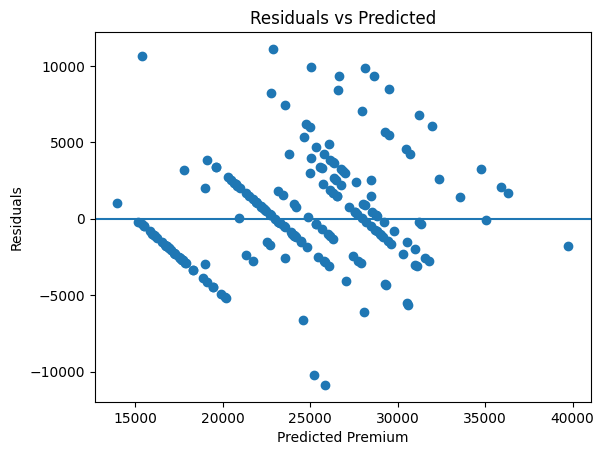

In [104]:
Residuals = y_test - y_pred
plt.figure()
plt.scatter(y_pred, Residuals)
plt.axhline(0)
plt.xlabel('Predicted Premium')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()

##### **Insight** : Model violates the **homoscedasticity** assumption of linear regression,which is expected in insurance premium prediction due to increasing uncertainty at higher risk levels.

**Let's go with Log transformation of target**

In [105]:
# Log tranformation
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [106]:
# Model evaluation with log transformation
LR = LinearRegression()
LR.fit(X_train,y_train_log)
r2 = LR.score(X_train,y_train_log)
print(r2)
y_pred_log = LR.predict(X_test)
mae = mean_absolute_error(y_test_log, y_pred_log)
rmse = root_mean_squared_error(y_test_log, y_pred_log)
r2 = r2_score(y_test_log, y_pred_log)

print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

0.6373921263033455
Mean Absolute Error: 0.11741276493032361
Root Mean Squared Error: 0.1500383017617842
R-squared: 0.7165732081394344


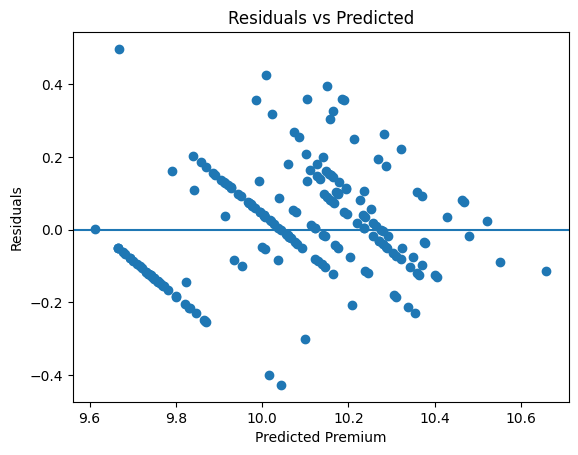

In [107]:
Residuals_log = y_test_log - y_pred_log
plt.figure()
plt.scatter(y_pred_log, Residuals_log)
plt.axhline(0)
plt.xlabel('Predicted Premium')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()

**Insight** : Still the hetroscedasticity persists due to exist of complex and non linear interactions with key health indicators. Hence, Let's go with tree based model to handle non linearity.

**8.2 Random Forest Regression:**

In [108]:

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train,y_train)
print(rf.score(X_train,y_train))
y_pred = rf.predict(X_test)
print(rf.score(X_test,y_test))
print(mean_absolute_percentage_error(y_test,y_pred))

0.9591535541160753
0.8621752680994014
0.05804056210382342


In [109]:
# Feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feat_imp = pd.DataFrame({
    'Feature': X_train.columns[indices],
    'Importance': importances[indices]
})

print(feat_imp)


                   Feature  Importance
0                      Age    0.631524
1                      BMI    0.153388
2           AnyTransplants    0.095195
3       AnyChronicDiseases    0.039144
4   NumberOfMajorSurgeries    0.031463
5  HistoryOfCancerInFamily    0.022830
6    BloodPressureProblems    0.010284
7                 Diabetes    0.009452
8           KnownAllergies    0.006721


**8.3 Random Forest Cross Validation:**

In [110]:
# Implement RandomizedSearch CV
RF_grid = {
    'n_estimators': [100, 200,300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [111]:

Random_search = RandomizedSearchCV(rf,RF_grid,cv=5,n_jobs=-1)
Random_search.fit(X_train,y_train)


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400]})

In [112]:
print(Random_search.best_params_)
print(Random_search.best_score_)
print(Random_search.best_estimator_)

{'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}
0.6962353791719864
RandomForestRegressor(max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=10, n_estimators=300, random_state=42)


In [113]:
best_RF = Random_search.best_estimator_
print(best_RF.score(X_train,y_train))
y_pred = best_RF.predict(X_test)
print(best_RF.score(X_test,y_test))

0.8199774353249795
0.8281039871142137


**Insight :** Random Forest with hyperparameter tuning using RandomizedSearchCV which performs k-fold cross-validation demonstrates better generalization, while the untuned Random Forest model exhibits moderate overfitting.


In [114]:
# Feature Importances

importances = best_RF.feature_importances_
indices = np.argsort(importances)[::-1]
feat_imp = pd.DataFrame({
    'Feature': X_train.columns[indices],
    'Importance': importances[indices]
})
print(feat_imp)

                   Feature  Importance
0                      Age    0.671677
1           AnyTransplants    0.099247
2                      BMI    0.090437
3   NumberOfMajorSurgeries    0.052975
4       AnyChronicDiseases    0.035626
5    BloodPressureProblems    0.018298
6  HistoryOfCancerInFamily    0.016122
7                 Diabetes    0.009146
8           KnownAllergies    0.006470


**8.4 XGBOOST**

In [115]:
# XGBOOST implementation

#XGB = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgboost_model = xgb.XGBRegressor(
     n_estimators=1000,
    learning_rate=0.03,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_weight=5,
    gamma=0.5,
    reg_alpha=0.5,
    reg_lambda=1.5,
    random_state=42
)
xgboost_model.fit(X_train, y_train)
print(xgboost_model.score(X_train, y_train))
y_pred = xgboost_model.predict(X_test)
print(xgboost_model.score(X_test, y_test))

0.8667333722114563
0.8317714929580688


**8.5 Light GBM**

In [116]:
# Light GBM implementation
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
LGBM = lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
LGBM.fit(X_train, y_train)
print(LGBM.score(X_train, y_train))
y_pred = LGBM.predict(X_test)
print(LGBM.score(X_test, y_test))


0.8846867845062891
0.8483970244037402


**Insight:**
EvenThough XGBoost is a strong challenger model, but Light GBM generalizes the data best and is therefore selected as the final model, while tuned Random forest serves as the base line model.

**9. Model Evaluation and Perfomrance:**

In [117]:
y_test.value_counts().sort_values(ascending=True)

,count
PremiumPrice,
22000,1
36000,1
34000,1
18000,1
26000,1
16000,1
19000,2
21000,6
31000,8


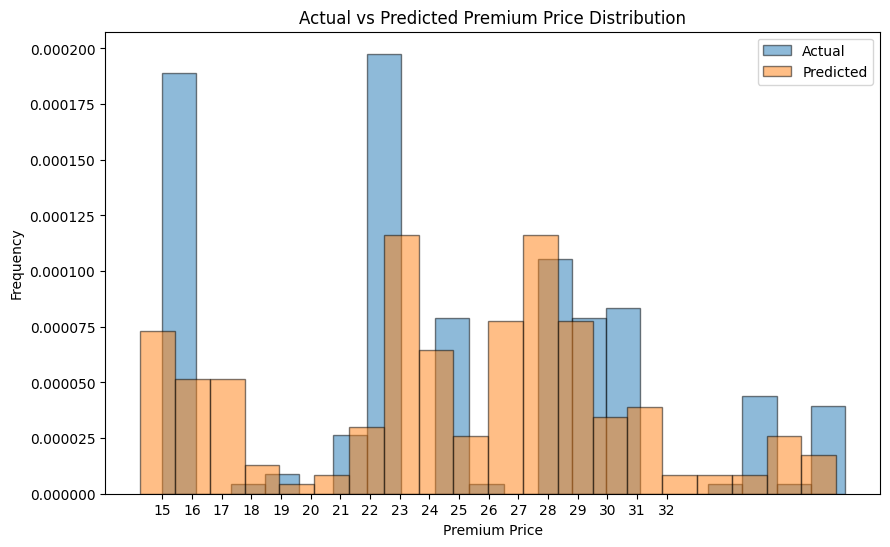

In [118]:
# Actual vs Predicted Premium Price
bins = 20
plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=bins, alpha=0.5, label='Actual', density=True, edgecolor='black')
plt.hist(y_pred, bins=bins, alpha=0.5, label='Predicted',density=True, edgecolor='black')
plt.xticks(np.arange(15000,33000, 1000), np.arange(15,33,1))
plt.xlabel('Premium Price')
plt.ylabel('Frequency')
plt.title('Actual vs Predicted Premium Price Distribution')
plt.legend()
plt.show()

**Insight:**
The model performs consistently across most age groups, with slightly higher prediction variance for older age segments due to increased health complexity.

In [119]:
df['PremiumPrice'].max()

40000

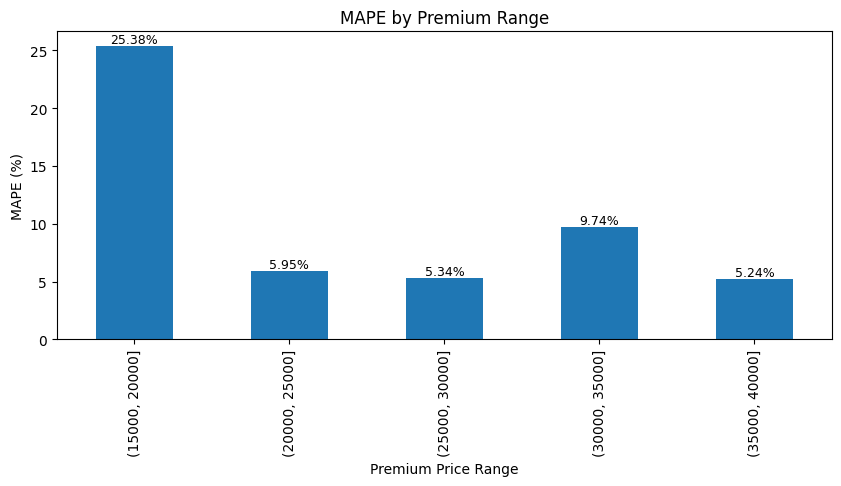

In [120]:
# Create bins
bins = np.arange(15000, 40001, 5000)

# Create evaluation dataframe
df_eval = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred
})

# Bin based on actual premium
df_eval['bin'] = pd.cut(df_eval['actual'], bins)

# Calculate MAPE by bin
mape_by_bin = (
    df_eval.groupby('bin')
    .apply(lambda x: np.mean(np.abs((x.actual - x.predicted) / x.actual)) * 100)
)

# Plot
ax = mape_by_bin.plot(kind='bar', figsize=(10,4), title='MAPE by Premium Range')
ax.set_ylabel('MAPE (%)')
ax.set_xlabel('Premium Price Range')

# 🔹 Add value labels on bars
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.2f}%',
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.show()


**Insight** :

The model accuracy is reliable for mid to high premum customers(20 to 40 K). Lower performance in the 15k to 20k segment is driven by the insufficient dara rather than model weakness.





Text(0, 0.5, 'Frequency')

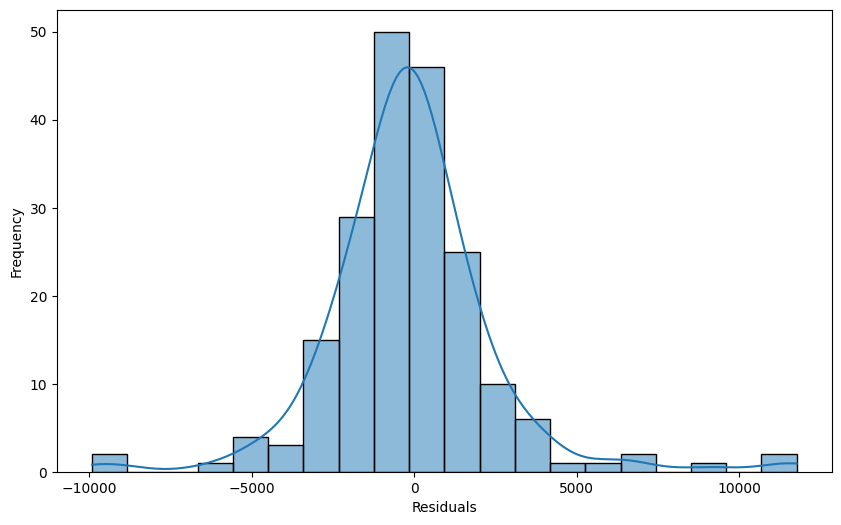

In [121]:
# Residual distribution
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=20, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')

**Insight: **
Residual distribution follows normal distribution, hence it is a good generalization model.

## **Model Performance evaluation:**

In [122]:
# Age binning
X_testModel = X_test.copy()
X_testModel['Age_bin'] = pd.cut(X_testModel['Age'], bins=[0, 18, 25, 30, 45, 66])

In [123]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def segment_performance(df, feature, y_true, y_pred):
    df_temp = df.copy()
    df_temp['true'] = y_true
    df_temp['pred'] = y_pred

    print(f"\n===== Performance by {feature} =====")

    perf = df_temp.groupby(feature).apply(
        lambda x: pd.Series({
            'R2': r2_score(x['true'], x['pred']),
            'MAE': mean_absolute_error(x['true'], x['pred']),
            'RMSE': mean_squared_error(x['true'], x['pred']) ** 0.5,
            'Count': len(x)
        })
    )

    print(perf)
    return perf


In [124]:
# Age bin segment analysis
segment_performance(X_testModel, 'Age_bin', y_test, y_pred)


===== Performance by Age_bin =====
                R2          MAE         RMSE  Count
Age_bin                                            
(0, 18]  -0.437847  3100.406711  4915.671189    6.0
(18, 25]  0.000000  1412.685108  1656.781241   23.0
(25, 30]  0.474919  1204.686451  1704.736506   19.0
(30, 45]  0.776871  1320.188962  2322.649532   64.0
(45, 66]  0.486623  2011.156073  2794.162972   86.0


,R2,MAE,RMSE,Count
Age_bin,,,,
"(0, 18]",-0.437847,3100.406711,4915.671189,6.0
"(18, 25]",0.000000,1412.685108,1656.781241,23.0
"(25, 30]",0.474919,1204.686451,1704.736506,19.0
"(30, 45]",0.776871,1320.188962,2322.649532,64.0
"(45, 66]",0.486623,2011.156073,2794.162972,86.0


**Insights:**

The model performs well for most age groups, espcially 30 to 45 years. Results for very young ages are unreliable due to limited data, error are slightly increase for older people which is expected. model can improve the performance if we can add more data.

In [125]:
bool_features = [
    'Diabetes',
    'BloodPressureProblems',
    'AnyTransplants',
    'AnyChronicDiseases',
    'KnownAllergies',
    'HistoryOfCancerInFamily',
    'NumberOfMajorSurgeries'
]

In [126]:
X_testModel['AnyTransplants'].value_counts()

,count
AnyTransplants,
0,187
1,11


In [127]:
from sklearn.metrics import r2_score
import pandas as pd

results = []

# Copy to avoid modifying original
X_testModel_eval = X_testModel.copy()
X_testModel_eval['y_actual'] = y_test
X_testModel_eval['y_pred'] = y_pred

for feature in bool_features:
    for val in [0, 1]:  # Iterate over values 0 and 1 for each boolean feature
        subset = X_testModel_eval[X_testModel_eval[feature] == val]

        if len(subset) < 20:
            continue

        results.append({
            'Feature': feature,
            'Value': val,
            'Count': len(subset),
            'R2_Score': round(
                r2_score(subset['y_actual'], subset['y_pred']), 3
            )
        })

# Final table
r2_table = pd.DataFrame(results)
print(r2_table)

                    Feature  Value  Count  R2_Score
0                  Diabetes      0    118     0.904
1                  Diabetes      1     80     0.741
2     BloodPressureProblems      0    101     0.904
3     BloodPressureProblems      1     97     0.753
4            AnyTransplants      0    187     0.811
5        AnyChronicDiseases      0    163     0.850
6        AnyChronicDiseases      1     35     0.770
7            KnownAllergies      0    156     0.845
8            KnownAllergies      1     42     0.846
9   HistoryOfCancerInFamily      0    172     0.842
10  HistoryOfCancerInFamily      1     26     0.833
11   NumberOfMajorSurgeries      0     91     0.872
12   NumberOfMajorSurgeries      1     83     0.809


**Insights:**
R2 score is consistently high (0.76 to 0.83)
even for smaller subgroups performance remains accpetable. this implies model generalizes well for high risk indivuals.

**Prediction Intervals**

**Quantile Regression:**


In [128]:
import lightgbm as lgb
import numpy as np
import pandas as pd

# Lower bound (10%)
lgb_lower = lgb.LGBMRegressor(
    objective='quantile',
    alpha=0.10,
    n_estimators=100,
    random_state=42,
    verbose=-1
)

# Upper bound (90%)
lgb_upper = lgb.LGBMRegressor(
    objective='quantile',
    alpha=0.90,
    n_estimators=100,
    random_state=42,
    verbose=-1
)

# Mean prediction
lgb_mean = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=100,
    random_state=42,
    verbose=-1
)

lgb_lower.fit(X_train, y_train)
lgb_upper.fit(X_train, y_train)
lgb_mean.fit(X_train, y_train)


LGBMRegressor(objective='regression', random_state=42, verbose=-1)

In [129]:
lower_pi = lgb_lower.predict(X_test)
upper_pi = lgb_upper.predict(X_test)
mean_pred = lgb_mean.predict(X_test)


In [130]:
pi_df = pd.DataFrame({
    "Prediction": mean_pred,
    "Lower_PI": lower_pi,
    "Upper_PI": upper_pi
})

pi_df.head()


,Prediction,Lower_PI,Upper_PI
0,31522.008207,22999.787509,32213.656025
1,28510.715395,22999.787509,29270.825017
2,32338.033649,25684.104919,34999.893754
3,14256.016544,15000.000000,22934.352352
4,26407.456414,22999.787509,35300.141943


In [131]:
22999.787509 - 32213.656025

-9213.868515999999

**Insight:**
The model predicts low to moderate premiums with high confidence, while higher premium predictions show increased uncertainty due to greater variability and fewer comparable records.

**Model Interpretability and Explainability:**

**SHAP:**

In [132]:
# Feature importance
importances = LGBM.feature_importances_
indices = np.argsort(importances)[::-1]
feat_imp = pd.DataFrame({
    'Feature': X_train.columns[indices],
    'Importance': importances[indices]
})
feat_imp

,Feature,Importance
0,BMI,1256
1,Age,939
2,NumberOfMajorSurgeries,177
3,BloodPressureProblems,130
4,Diabetes,119
5,AnyTransplants,87
6,AnyChronicDiseases,80
7,HistoryOfCancerInFamily,60
8,KnownAllergies,53


**Insight** : BMI and Age are the mosy key driven features for the insurance premium prediction.

In [133]:
# Standard shap values
import shap
explainer = shap.TreeExplainer(best_RF)
shap_values = explainer.shap_values(X_test)
np.shape(shap_values)

(198, 9)

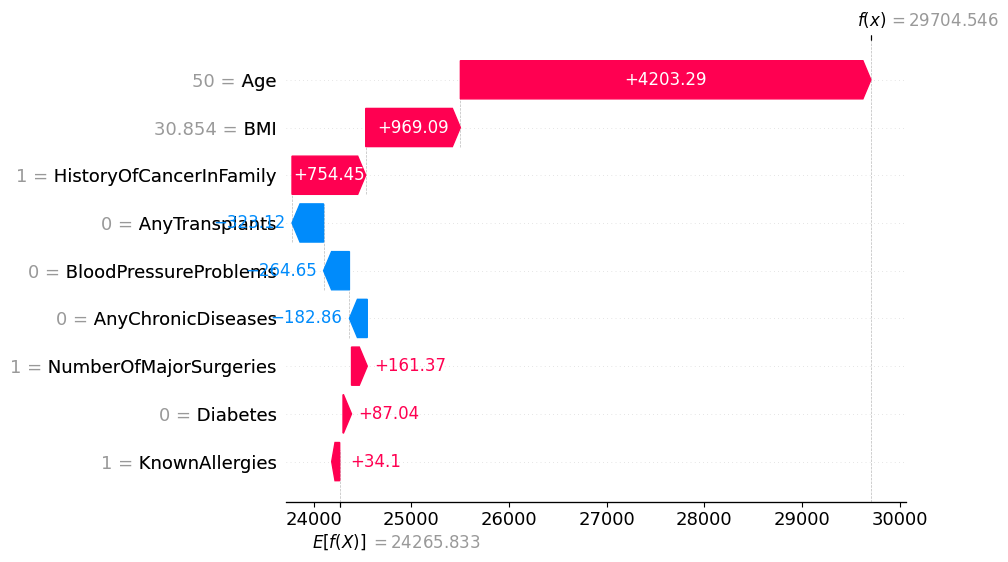

In [134]:
# water fall plot
shap_explanation = shap.Explanation(values=shap_values[0], base_values=explainer.expected_value, data=X_test.iloc[0])
shap.plots.waterfall(shap_explanation)

**SHAP Insights:**

 The model starts with an **average Expected Premium price of about 24,271**.

 Based on the customer detail, it increased to around **29,833**

**Key drivers which increase the premium:**

*    **Age** - 50 years is the biggest driver, adding ~4200 Rs, as risk generally increase with age.

*   **BMI** - 31 value which adds ~950 Rs, indicating second higher health risk.

*   **Family history of cancer** adds ~₹736Rs, increasing expected medical risk.
*   **Past Major surgeries**  add a small increase (~241Rs)


**Factors reducing the premium:**

*  No transplant history
*  No Blood pressure problems.
*  No chronic deceases.

**Other Observations:**

**Diabetes and Known allergies** have a very small impact on the premium price.


**Model Insights:**

* **Age is the strongest driver of premium**
As age increases, insurance premium generally increases due to higher health risk.

* **Health conditions significantly increase premium**
Customers with diabetes, chronic diseases, blood pressure problems, or a history of major surgeries tend to have higher premiums.

* **Obesity matters**
Higher weight/BMI is associated with higher premium, especially when combined with other health issues.

* **Multiple risk factors compound the premium**
Premiums rise sharply when age and health conditions occur together (for example, older age + chronic disease).

* **Model predicts low and moderate premiums more accurately**
Predictions are more reliable for healthy or moderately risky customers.

* **High premiums have more uncertainty**
For high-risk customers, prediction intervals are wider, indicating higher variability and uncertainty in costs.

* **LightGBM generalizes best**
Compared to Random Forest and XGBoost, LightGBM balances bias and variance well and performs consistently on unseen data.
